In [48]:
from tqdm import tqdm

import math
import random
import itertools
from functools import lru_cache

import torch
import numpy as np
from scipy.stats import lognorm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [49]:
"""
Features of the model:
- #TODO missing sign epistasis in this construction--because interactions are sampled independently, I might be missing some important correlation structure
- Multiple lengths
- Epistatic interactions are defined in terms of relative positions of elements in the sequence
- This means interaction types are shared but different positions have different interaction types available
- Boltzmann distribution for energy
- Interactions of upto order 4
- Interactions only increase the energy, so that the exponentials in the Boltzmann distribution are bounded
"""

'\nFeatures of the model:\n- #TODO missing sign epistasis in this construction--because interactions are sampled independently, I might be missing some important correlation structure\n- Multiple lengths\n- Epistatic interactions are defined in terms of relative positions of elements in the sequence\n- This means interaction types are shared but different positions have different interaction types available\n- Boltzmann distribution for energy\n- Interactions of upto order 4\n- Interactions only increase the energy, so that the exponentials in the Boltzmann distribution are bounded\n'

In [50]:
L_max = 8 # maximum sequence length
A = 3 # alphabet size
D_max = 3 # maximum order of interactions
N_seq_space = sum([A ** l for l in range(1, L_max + 1)]) # 1 is for the mask state, sum over all lengths less than L
N_data = sum([(A + 1) ** l for l in range(1, L_max + 1)]) # 1 is for the mask state, sum over all lengths less than L
print(N_seq_space, N_data)

9840 87380


In [51]:
# Number of interactions needed
# WLOG consider the first position in the d interactors to be at position 0
# then there are L_max - 1 choose d - 1 ways to choose the other d - 1 positions
# Note a bunch of these terms won't be "physical" because the chosen position can be out of bounds for shorter lengths
N_interactions = sum([math.comb(L_max - 1, d - 1) * (A ** d) for d in range(1, D_max + 1)])
print(N_interactions)

633


# Calculating Dataset Probabilities

In [52]:
# Energy function
# Interaction energies are deterministic
# TODO: should length decrease energy cost? Otherwise, just because there are more possible interactions, longer sequences will be disfavored
# Probability of interaction is exponential in the distance between each pair of positions
# Interaction contributions are geometrically distributed with support 1, 2, 3, ... with p=0.5 so mean 2
# We need to build up the interaction terms and then have a function to compute the energy of a sequence
# An easy way to do this is to make a helper function that takes a list of the positions and tokens, and outputting the interaction energy
# we can wrap this with a decorator to memoize it, that way it can be stochastic the first time but deterministic later

seq_to_str = lambda seq: ",".join(map(str, seq))
str_to_seq = lambda s: list(map(int, s.split(",")))

@lru_cache(maxsize=None)
def interaction(positions, tokens, distance_decay=0.5):
    # Sort positions in increasing order and remap tokens accordingly
    positions, tokens = str_to_seq(positions), str_to_seq(tokens)
    assert len(positions) == len(tokens)
    d = len(positions)
    sorted_indices = sorted(range(len(positions)), key=lambda k: positions[k])
    positions = [positions[i] for i in sorted_indices]
    tokens = [tokens[i] for i in sorted_indices]
    # interaction strength
    interaction_distance = 0
    for i in range(d):
        for j in range(i + 1, d):
            # print(d)
            interaction_distance += positions[j] - positions[i]
    # interaction occurs with probability equal to strength (capped at 1)
    interaction_probability = math.exp(-distance_decay * interaction_distance)
    if interaction_probability < random.uniform(0, 1):
        return 0 # does into an exponential of the sum of energies so it doesn't change the overall energy 
    else:
        # if it is a vertex energy, we want the mean to be 1 not 2 since they are guaranteed to occur
        energy_cost = int(d > 1) + torch.distributions.geometric.Geometric(probs=0.5).sample().float()
        return energy_cost

@lru_cache(maxsize=None)
def unnorm_log_prob(sequence, temperature=1.0, length_scale=2.0):
    # sequence is a list of integers in 0, ..., A-1
    sequence = str_to_seq(sequence)
    energy = 0
    for i in range(len(sequence)):
        for d in range(1, D_max + 1):
            if i + d <= len(sequence):
                # anchored at i so need to choose the other d - 1 positions
                for positions in itertools.combinations(range(i + 1, len(sequence)), d - 1):
                    positions = (i,) + positions
                    tokens = [sequence[p] for p in positions]
                    energy += interaction(seq_to_str(positions), seq_to_str(tokens))
    energy += length_scale * (L_max - len(sequence)) # correct a bit for length bias
    return -energy / temperature


@lru_cache(maxsize=None)
def partition_fn(temperature=1.0):
    # Compute the partition function Z = sum_{all sequences} exp(unnorm_log_prob)
    # Use log-sum-exp trick for numerical stability
    log_probs = []
    seqs = []
    for l in range(1, L_max + 1):
        for seq in tqdm(itertools.product(range(A), repeat=l), total=A**l, desc=f'Length {l}'):
            log_probs.append(unnorm_log_prob(seq_to_str(seq), temperature))
            seqs.append(seq)
    # log-sum-exp
    max_log_prob = max(log_probs)
    sum_exp = sum(math.exp(lp - max_log_prob) for lp in log_probs)
    Z = math.exp(max_log_prob) * sum_exp
    return Z, log_probs, seqs

@lru_cache(maxsize=None)
def prob(sequence, temperature=1.0):
    Z, log_probs, seqs = partition_fn(temperature)
    return math.exp(unnorm_log_prob(sequence, temperature)) / Z


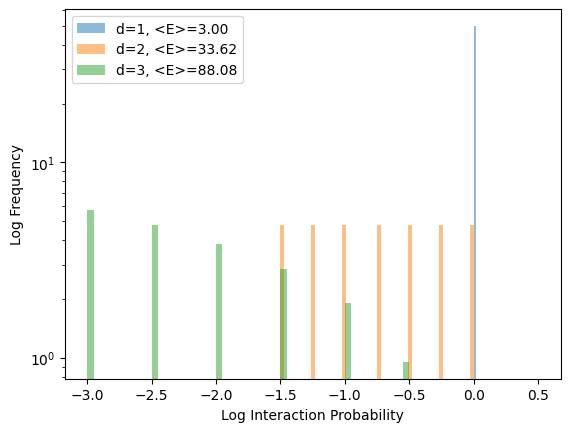

In [53]:
# Plot the histogram of interaction probabilities
distance_decay = 0.25
for d in range(1, D_max + 1):
    interaction_costs = []
    expected_interactions = 0
    for positions in itertools.combinations(range(L_max - 1), d - 1):
        positions = (0,) + positions
        interaction_distance = 0
        for i in range(d):
            for j in range(i + 1, d):
                interaction_distance += positions[j] - positions[i]
        interaction_cost = -distance_decay * interaction_distance
        interaction_costs.append(interaction_cost)
        interaction_probability = math.exp(interaction_cost)
        expected_interactions += interaction_probability * (A ** d)
    plt.hist(interaction_costs, bins=50, alpha=0.5, label=f'd={d}, <E>={expected_interactions:.2f}', density=True, log=True)
plt.xlabel('Log Interaction Probability')
plt.ylabel('Log Frequency')
plt.legend()
plt.show()

Length 8: 100%|██████████| 6561/6561 [00:02<00:00, 2974.77it/s]


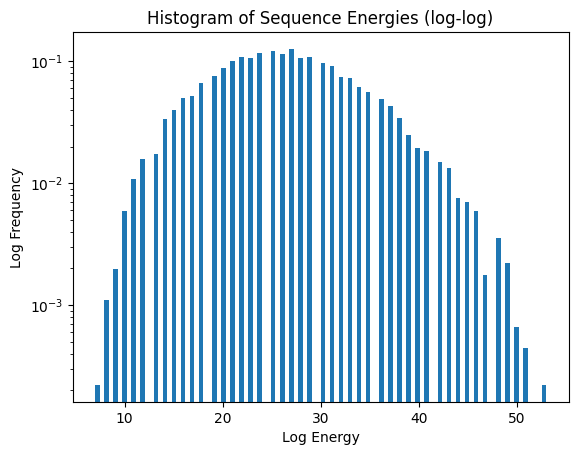

In [54]:
Z, log_probs, seqs = partition_fn(temperature=1.0)
energies = [math.exp(-lp) for lp in log_probs]
log_energies = [-lp for lp in log_probs]
plt.hist(log_energies, bins=100, log=True, density=True)
plt.xlabel('Log Energy')
plt.ylabel('Log Frequency')
plt.title('Histogram of Sequence Energies (log-log)')
plt.show()

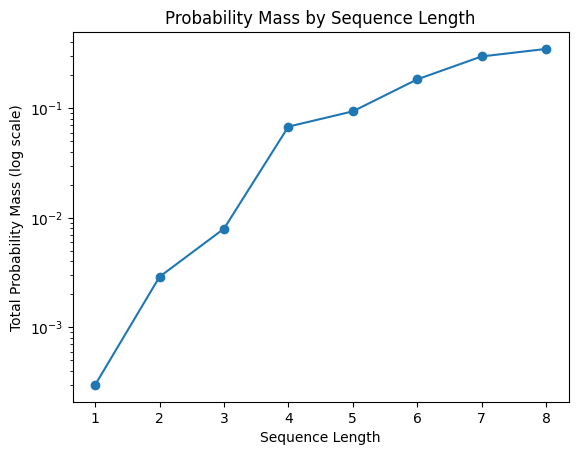

In [55]:
probs = np.exp(np.array(log_probs) - np.max(log_probs)) / np.sum(np.exp(np.array(log_probs) - np.max(log_probs)))
lengths = [len(seq) for seq in seqs]
prob_mass_by_length = [np.sum(probs[np.array(lengths) == l]) for l in range(1, max(lengths) + 1)]
plt.plot(range(1, max(lengths) + 1), prob_mass_by_length, marker='o')
plt.yscale('log')
plt.xlabel('Sequence Length')
plt.ylabel('Total Probability Mass (log scale)')
plt.title('Probability Mass by Sequence Length')
plt.show()

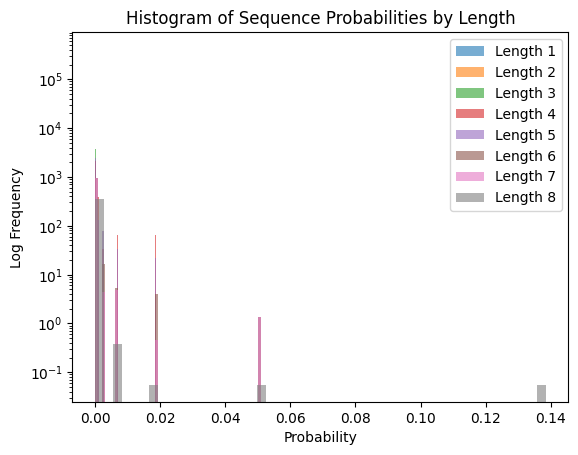

In [56]:
# Plot histograms of probabilities by sequence length
for l in range(1, max(lengths) + 1):
    plt.hist(probs[np.array(lengths) == l], bins=50, alpha=0.6, label=f'Length {l}', density=True, log=True)
plt.xlabel('Probability')
plt.ylabel('Log Frequency')
plt.title('Histogram of Sequence Probabilities by Length')
plt.legend()
plt.show()

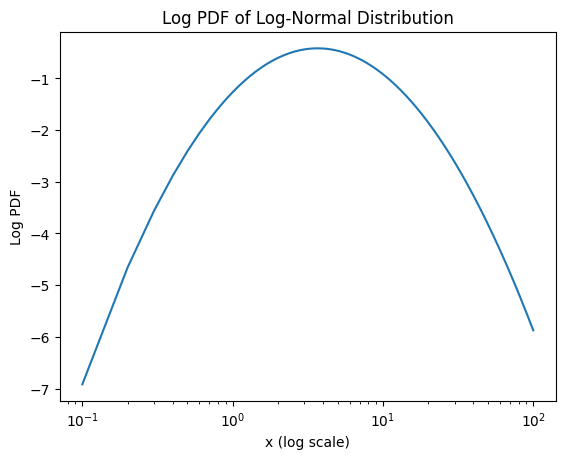

In [57]:
lognormal = lognorm(s=1.0, scale=np.exp(0))  # mean=0, sigma=1
x = np.linspace(0.01, 10, 1000)
pdf_lognormal = lognormal.pdf(x)
plt.semilogx(10 * x, np.log(pdf_lognormal))
plt.xlabel('x (log scale)')
plt.ylabel('Log PDF')
plt.title('Log PDF of Log-Normal Distribution')
plt.show()

# Model

In [58]:
from torch import nn
import torch.nn.functional as F
class sequence_model(nn.Module):
    def __init__(self, L_max, A, D_max, d_model=64, n_head=4, n_layers=1):
        super(sequence_model, self).__init__()
        self.embedding = nn.Embedding(A + 1, d_model)
        self.n_layers = n_layers
        self.n_head = n_head
        self.d_model = d_model
        self.head_dim = d_model // n_head
        self.layers = nn.ModuleList([
            nn.ModuleDict({
                'self_attn_q': nn.Linear(d_model, d_model),
                'self_attn_k': nn.Linear(d_model, d_model),
                'self_attn_v': nn.Linear(d_model, d_model),
                'self_attn_out': nn.Linear(d_model, d_model),
                'ffn1': nn.Linear(d_model, d_model),
                'ffn2': nn.Linear(d_model, d_model),
                'norm1': nn.LayerNorm(d_model),
                'norm2': nn.LayerNorm(d_model)
            }) for _ in range(n_layers)
        ])
        self.fc = nn.Linear(d_model, A)

    def forward(self, x):
        x_embed = self.embedding(x)
        seq_len = x_embed.size(1)
        mask = torch.triu(torch.ones(seq_len, seq_len, device=x.device), diagonal=1).bool()
        out = x_embed
        for layer in self.layers:
            # Multi-head self-attention
            q = layer['self_attn_q'](out)
            k = layer['self_attn_k'](out)
            v = layer['self_attn_v'](out)
            # [batch, seq, d_model] -> [batch, seq, n_head, head_dim]
            def split_heads(t):
                return t.view(t.size(0), t.size(1), self.n_head, self.head_dim).transpose(1, 2)
            qh, kh, vh = split_heads(q), split_heads(k), split_heads(v)
            # Attention scores
            attn_scores = torch.matmul(qh, kh.transpose(-2, -1)) / math.sqrt(self.head_dim)
            attn_scores = attn_scores.masked_fill(mask.unsqueeze(0).unsqueeze(1), float('-inf'))
            attn_weights = torch.softmax(attn_scores, dim=-1)
            attn_out = torch.matmul(attn_weights, vh)
            # Merge heads
            attn_out = attn_out.transpose(1, 2).contiguous().view(out.size(0), seq_len, self.d_model)
            attn_out = layer['self_attn_out'](attn_out)
            out = layer['norm1'](out + attn_out)
            # Feedforward
            ff = layer['ffn2'](torch.relu(layer['ffn1'](out)))
            out = layer['norm2'](out + ff)
        logits = self.fc(out)
        logits = F.log_softmax(logits, dim=-1)
        return logits


In [59]:
print(N_seq_space, len(np.array(energies)))

9840 9840


In [60]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'
N_dataset = 1000
N_mask = 2 ** L_max

# Split indices for train/val
train_indices, val_indices = train_test_split(np.arange(N_seq_space), test_size=0.2, random_state=42, stratify=[len(seq) for seq in seqs])

# Sample sequences for train/val using probs
train_sample_indices = np.random.choice(train_indices, size=(N_dataset,), replace=True, p=probs[train_indices]/probs[train_indices].sum())
val_sample_indices = np.random.choice(val_indices, size=(N_dataset // 5,), replace=True, p=probs[val_indices]/probs[val_indices].sum())

train_dataset = [seqs[i] for i in train_sample_indices]
val_dataset = [seqs[i] for i in val_sample_indices]

def make_masked_dataset(dataset, L_max, A, N_mask):
    Xt_by_length = [[] for _ in range(L_max)]
    X1_by_length = [[] for _ in range(L_max)]
    for seq in dataset:
        for _ in range(N_mask):
            n_masked = np.random.randint(1, len(seq) + 1)
            masked_positions = np.random.choice(len(seq), size=n_masked, replace=False)
            masked_seq = [A if i in masked_positions else seq[i] for i in range(len(seq))]
            Xt_by_length[len(seq) - 1].append(masked_seq)
            X1_by_length[len(seq) - 1].append(seq)
    print(torch.tensor(Xt_by_length[-1]).shape, torch.tensor(X1_by_length[-1]).shape)
    return [
        (torch.tensor(xt, dtype=torch.long).to(device), torch.tensor(x1, dtype=torch.long).to(device))
        for xt, x1 in zip(Xt_by_length, X1_by_length) if len(xt) > 0
    ]

train_datasets_by_length = make_masked_dataset(train_dataset, L_max, A, N_mask)
val_datasets_by_length = make_masked_dataset(val_dataset, L_max, A, N_mask)

train_dataset_lengths = [len(d[0]) for d in train_datasets_by_length]
val_dataset_lengths = [len(d[0]) for d in val_datasets_by_length]
print(train_dataset_lengths, val_dataset_lengths)

torch.Size([97280, 8]) torch.Size([97280, 8])
torch.Size([10752, 8]) torch.Size([10752, 8])
[256, 512, 1792, 19200, 26112, 38144, 72704, 97280] [768, 1280, 2048, 1536, 18944, 15872, 10752]


In [61]:
batch_size = 32
epochs = 1
N_iterations = int(sum([l // batch_size + int(l % batch_size > 0) for l in val_dataset_lengths]) * epochs)
print(N_iterations, train_dataset_lengths)

1600 [256, 512, 1792, 19200, 26112, 38144, 72704, 97280]


In [62]:
model = sequence_model(L_max, A, D_max).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
loss_weights = torch.zeros(A).to(device)
loss_weights[-1] = 1.0 # only care about the masked predictions
loss_fn = nn.NLLLoss(weight=loss_weights, ignore_index=-1)

In [63]:
from tqdm import trange

model.train()
for i in trange(N_iterations, desc="Training"):
    batch_seq_len_idx = np.random.choice(len(train_dataset_lengths), p=np.array(train_dataset_lengths) / sum(train_dataset_lengths))
    batch_dataset = train_datasets_by_length[batch_seq_len_idx]
    batch_indices = np.random.choice(len(batch_dataset[0]), size=min(batch_size, len(batch_dataset[0])), replace=False)
    Xt_batch_BL = batch_dataset[0][batch_indices]
    X1_batch_BL = batch_dataset[1][batch_indices]
    optimizer.zero_grad()
    # print(batch_dataset[0].shape, batch_dataset[1].shape, len(batch_dataset), len(batch_indices))
    # print(Xt_batch_BL.shape, X1_batch_BL.shape)
    logits_BLA = model(Xt_batch_BL)
    # print(logits_BLA.shape)
    logits_x1_BL = logits_BLA.gather(2, X1_batch_BL.unsqueeze(-1)).squeeze(-1)
    loss = torch.sum(-logits_x1_BL * (Xt_batch_BL == A).float()) / torch.sum((Xt_batch_BL == A).float())
    # print(loss)
    loss.backward()
    optimizer.step()
    if i % 100 == 0:
        with torch.no_grad():
            model.eval()
            val_losses = []
            val_dataset_idx = np.random.choice(len(val_dataset_lengths), p=np.array(val_dataset_lengths) / sum(val_dataset_lengths))
            val_dataset = val_datasets_by_length[val_dataset_idx]
            val_batch_indices = np.random.choice(len(val_dataset[0]), size=min(batch_size, len(val_dataset[0])), replace=False)
            Xt_val_batch, X1_val_batch = (val_dataset[0][val_batch_indices], val_dataset[1][val_batch_indices])
            X1_val_batch = torch.where(Xt_val_batch == A, X1_val_batch, -1)
            val_logits = model(Xt_val_batch)
            val_loss = loss_fn(val_logits.view(-1, A), X1_val_batch.view(-1)).item()
            val_losses.append(val_loss)
            avg_val_loss = np.mean(val_losses) if val_losses else float('nan')
            print(f"Step {i}: train loss = {loss.item():.4f}, val loss = {avg_val_loss:.4f}")
            # # Product of likelihoods for 10 samples from the validation dataset
            # sample_idx = np.random.choice(len(val_dataset[1]), size=10, replace=False)
            # val_samples = val_dataset[1][sample_idx].cpu().numpy()
            # # print(val_samples)
            # val_likelihoods = [prob(seq_to_str(seq.tolist()), temperature=1.0) for seq in val_samples]
            # # print(val_likelihoods)
            # # input()
            # val_likelihood_product = np.sum(np.log(val_likelihoods))
            # print("Product of likelihoods for 10 validation samples:", val_likelihood_product)
            # # print("Likelihoods for 10 validation samples:", val_likelihoods)

            # # Likelihoods for 10 samples from the model
            # model.eval()
            # model_samples = []
            # model_sample_likelihoods = []
            # for _ in range(10):
            #     seq_len_idx = np.random.choice(len(val_dataset_lengths), p=np.array(val_dataset_lengths) / sum(val_dataset_lengths))
            #     seq_len = len(val_datasets_by_length[seq_len_idx][0][0])
            #     # print(seq_len)
            #     seq = [A] * seq_len
            #     ordering = np.random.permutation(seq_len)
            #     for idx in ordering:
            #         input_seq = torch.tensor([seq], dtype=torch.long).to(device)
            #         logits_BLA = model(input_seq)[0, idx]
            #         probs_token = torch.exp(logits_BLA)
            #         token = torch.multinomial(probs_token, num_samples=1).item()
            #         seq[idx] = token
            #     model_samples.append(seq)
            #     model_sample_likelihoods.append(np.log(prob(seq_to_str(seq), temperature=1.0)))
            # # print("Likelihoods for 10 model samples:", model_sample_likelihoods)
            # print("Product of likelihoods for 10 model samples:", np.sum(model_sample_likelihoods))
            # print("Validation samples:")
            # print(val_samples[:5])
            # print("Model samples:")
            # print(model_samples[:5])
            # print(val_logits)
            model.train()

Training:   1%|▏         | 22/1600 [00:00<00:07, 211.02it/s]

Step 0: train loss = 1.1845, val loss = 1.1510


Training:   8%|▊         | 134/1600 [00:00<00:06, 218.64it/s]

Step 100: train loss = 1.0927, val loss = 1.1755


Training:  15%|█▍        | 236/1600 [00:01<00:07, 186.74it/s]

Step 200: train loss = 1.0445, val loss = 1.1751


Training:  21%|██        | 329/1600 [00:01<00:05, 220.27it/s]

Step 300: train loss = 1.0280, val loss = 1.1745


Training:  27%|██▋       | 431/1600 [00:02<00:04, 240.16it/s]

Step 400: train loss = 1.0565, val loss = 1.1797


Training:  34%|███▍      | 543/1600 [00:02<00:03, 268.51it/s]

Step 500: train loss = 0.9903, val loss = 1.2048


Training:  41%|████      | 655/1600 [00:02<00:03, 275.10it/s]

Step 600: train loss = 1.0055, val loss = 1.2047


Training:  46%|████▋     | 741/1600 [00:03<00:03, 279.39it/s]

Step 700: train loss = 1.0735, val loss = 1.1401


Training:  54%|█████▎    | 856/1600 [00:03<00:02, 277.47it/s]

Step 800: train loss = 1.0053, val loss = 1.1275


Training:  59%|█████▉    | 941/1600 [00:03<00:02, 276.12it/s]

Step 900: train loss = 1.0524, val loss = 1.1576


Training:  64%|██████▎   | 1019/1600 [00:04<00:02, 218.02it/s]

Step 1000: train loss = 0.9468, val loss = 1.1461


Training:  70%|███████   | 1123/1600 [00:04<00:02, 187.42it/s]

Step 1100: train loss = 0.9049, val loss = 1.1148


Training:  77%|███████▋  | 1238/1600 [00:05<00:01, 186.48it/s]

Step 1200: train loss = 0.9943, val loss = 1.2123


Training:  83%|████████▎ | 1334/1600 [00:05<00:01, 184.57it/s]

Step 1300: train loss = 0.9886, val loss = 1.1138


Training:  90%|█████████ | 1441/1600 [00:06<00:00, 201.05it/s]

Step 1400: train loss = 1.0065, val loss = 1.1071


Training:  95%|█████████▌| 1525/1600 [00:06<00:00, 202.24it/s]

Step 1500: train loss = 1.0586, val loss = 1.1514


Training: 100%|██████████| 1600/1600 [00:07<00:00, 219.47it/s]


In [64]:
num_samples = 100
sampled_dataset_probs = []
for i in range(num_samples):
    seq = train_dataset[i]
    seq_prob = probs[train_sample_indices[i]]
    sampled_dataset_probs.append(seq_prob)
    print(f"Sequence {i}: {seq}, Probability: {seq_prob:.4e}")

Sequence 0: (0, 2, 1, 2, 2, 1), Probability: 9.3319e-04
Sequence 1: (1, 2, 1, 2, 1, 1), Probability: 1.8744e-02
Sequence 2: (1, 2, 0, 2, 1, 1, 2), Probability: 6.8954e-03
Sequence 3: (1, 1, 1, 2, 1, 0), Probability: 6.8954e-03
Sequence 4: (1, 1, 1, 2, 2, 0, 1, 1), Probability: 1.3850e-01
Sequence 5: (0, 2, 0, 2, 1, 1, 0, 0), Probability: 3.4330e-04
Sequence 6: (0, 2, 1, 2, 1, 1), Probability: 1.8744e-02
Sequence 7: (1, 1, 1, 2, 2, 0, 1, 1), Probability: 1.3850e-01
Sequence 8: (1, 1, 1, 2, 2, 0, 1, 1), Probability: 1.3850e-01
Sequence 9: (1, 1, 1, 2, 2, 0, 1, 0), Probability: 6.8954e-03
Sequence 10: (1, 2, 1, 2, 1, 1, 2), Probability: 5.0950e-02
Sequence 11: (0, 2, 1, 2, 1, 1), Probability: 1.8744e-02
Sequence 12: (1, 1, 1, 2, 2, 0, 1, 1), Probability: 1.3850e-01
Sequence 13: (0, 1, 1, 2, 2, 0), Probability: 9.3319e-04
Sequence 14: (1, 2, 0, 1, 1), Probability: 9.3319e-04
Sequence 15: (1, 1, 0, 2, 1, 0, 0, 1), Probability: 2.5367e-03
Sequence 16: (1, 1, 1, 2, 1, 1, 2, 2), Probability: 2

In [65]:
sampled_sequences = []
sampled_probs = []
sampled_model_probs = []

lengths = [len(seq) for seq in seqs]
probs = np.exp(np.array(log_probs) - np.max(log_probs)) / np.sum(np.exp(np.array(log_probs) - np.max(log_probs)))
lengths_arr = np.array(lengths)
length_prob_mass = np.array([np.sum(probs[lengths_arr == l]) for l in range(1, L_max + 1)])
length_prob_mass /= length_prob_mass.sum()

model.eval()
with torch.no_grad():
    for _ in range(num_samples):
        seq_len = np.random.choice(np.arange(1, L_max + 1), p=length_prob_mass)
        ordering = np.random.permutation(seq_len)
        seq = [A] * seq_len  # Start with all masked
        model_prob = 1.0
        for idx in ordering:
            input_seq = torch.tensor([seq], dtype=torch.long).to(device)
            logits_BLA = model(input_seq)[0, idx]
            probs_token = torch.exp(logits_BLA)
            token = torch.multinomial(probs_token, num_samples=1).item()
            model_prob *= probs_token[token].item()
            seq[idx] = token
        sampled_sequences.append(seq)
        sampled_model_probs.append(model_prob)
        sampled_probs.append(prob(seq_to_str(seq), temperature=1.0))

for seq, p_model, p_actual in zip(sampled_sequences, sampled_model_probs, sampled_probs):
    print(f"Sequence: {seq}, Probability: {p_model:.4e}, Actual Prob: {p_actual:.4e}")

Length 8: 100%|██████████| 6561/6561 [00:00<00:00, 762590.16it/s]


Sequence: [2, 0, 1, 1, 2, 0, 2], Probability: 2.6218e-04, Actual Prob: 2.8546e-10
Sequence: [0, 2, 1, 2, 1], Probability: 4.8346e-03, Actual Prob: 6.8954e-03
Sequence: [0, 0, 2, 1, 2, 1], Probability: 8.9852e-04, Actual Prob: 7.7597e-10
Sequence: [1, 2, 1, 2, 1, 1], Probability: 7.4060e-03, Actual Prob: 1.8744e-02
Sequence: [1, 1, 2, 1, 1, 2, 1, 1], Probability: 1.8239e-03, Actual Prob: 3.5229e-14
Sequence: [1, 1, 1, 0, 1, 0], Probability: 2.3555e-03, Actual Prob: 8.5096e-07
Sequence: [2, 1, 1, 1, 2, 1, 2], Probability: 1.2633e-03, Actual Prob: 5.7337e-09
Sequence: [1, 0, 1, 1, 1, 0], Probability: 1.5011e-03, Actual Prob: 4.6461e-05
Sequence: [0, 0, 2, 1, 1, 0], Probability: 5.5800e-04, Actual Prob: 5.7337e-09
Sequence: [2, 1, 1, 1, 2, 1], Probability: 6.9198e-03, Actual Prob: 5.7337e-09
Sequence: [2, 1, 2], Probability: 4.6976e-02, Actual Prob: 1.7092e-05
Sequence: [1, 2, 1, 1, 1, 1, 2, 2], Probability: 1.3176e-03, Actual Prob: 1.2629e-04
Sequence: [2, 1, 2, 1, 1, 1, 2], Probability: 

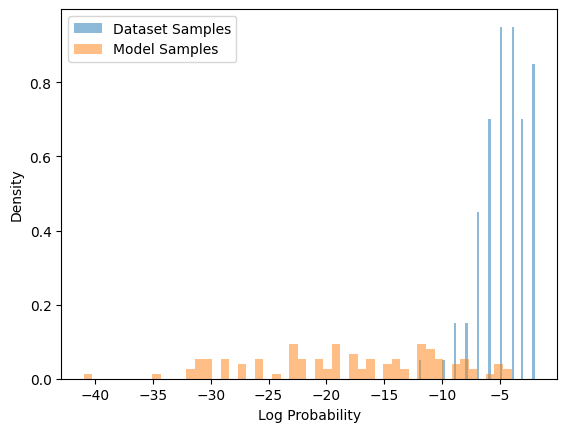

In [66]:
plt.hist(np.log(sampled_dataset_probs), bins=50, alpha=0.5, label='Dataset Samples', density=True)
plt.hist(np.log(sampled_probs), bins=50, alpha=0.5, label='Model Samples', density=True)
plt.xlabel('Log Probability')
plt.ylabel('Density')
plt.legend()
plt.show()